In [1]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop

In [2]:
import glob
import pandas as pd
import math
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]

In [11]:
all_filenames.extend([i for i in glob.glob('/content/drive/My Drive/TestData/*.{}'.format('csv'))])

In [12]:
len(all_filenames)

128

In [13]:
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']

In [14]:
x.head()

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100


In [15]:
y.head()

,y,subject,subject_ID,time
0,0,001,01,0.02
1,0,001,01,0.12
2,0,001,01,0.22
3,0,001,01,0.32
4,0,001,01,0.42


In [16]:
y['time'] = [x+0.005 for x in y['time']]

In [17]:
y.head()

,y,subject,subject_ID,time
0,0,001,01,0.025
1,0,001,01,0.125
2,0,001,01,0.225
3,0,001,01,0.325
4,0,001,01,0.425


In [19]:
# Merge x and y based on the matching timestamps and then filling na using forward fill
train_df = pd.merge(x,y, on=['time','subject', 'subject_ID'], how='left')

In [20]:
train_df.head()

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000,NaN
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025,0.0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050,NaN
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075,NaN
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100,NaN


In [21]:
train_df.fillna(method='backfill', inplace=True)

In [22]:
train_df.fillna(0, inplace=True)

In [35]:
# This is the number of hidden units in the RNN layer
hidden_size = 500
# This is the rate for the dropout layer
rate_dropout = 0.5
num_steps = 6

# TODO: Complete the definition of the network using a single simple RNN layer
model = Sequential()
# model.add(Embedding(130, 128, input_length=num_steps))
# model.add(Dropout(0.7))
model.add(LSTM(64, input_shape=(1,num_steps), return_sequences=True))
model.add(Bidirectional(LSTM(64, dropout=0.25, return_sequences=True)))
model.add(BatchNormalization())
model.add(LSTM(64, recurrent_activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             18176     
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 128)            66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128)            512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 134,404
Trainable params: 134,148
Non-trainable params: 256
_________________________________________________________________


In [ ]:
model.output_shape

(None, 4)

In [23]:
# CNN model
model_CNN = Sequential()

#Adding the input layer and first hidden layer
model_CNN.add(Dense(activation= 'relu', input_dim =6, units=500, kernel_initializer="uniform"))#rectifier activation function, include all input with one hot encoding
model_CNN.add(BatchNormalization())
#Adding second hidden layer
model_CNN.add(Dense(activation= 'relu',units=500, kernel_initializer="uniform")) #rectifier activation function
model_CNN.add(Dropout(0.25))
#Adding the Output Layer
model_CNN.add(Dense(activation='softmax', units=4, kernel_initializer="uniform")) 
#Compiling ANN - stochastic gradient descent
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])#stochastic gradient descent
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               3500      
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2004      
Total params: 258,004
Trainable params: 257,004
Non-trainable params: 1,000
_________________________________________________________________


In [24]:
model_CNN.input_shape

(None, 6)

In [26]:
model_CNN.output_shape

(None, 4)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df['x1', 'x2', 'x3', 'x4', 'x5', 'x6'], train_df['y'], test_size=0.33, random_state=42)

In [27]:
# Oversampling using SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
unique, counts = np.unique(y, return_counts=True)

In [30]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[1197398 1197398 1197398 1197398]


In [36]:
X_train = X_train.reshape(-1,1,6)
X_test = X_test.reshape(-1,1,6)

In [ ]:
X_train.shape

(536337, 6)

In [32]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Training RNN model
RNN_history = model.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test))


Epoch 1/20
100283/100283 [==============================] - 770s 8ms/step - loss: 1.2653 - categorical_accuracy: 0.4090 - val_loss: 1.2105 - val_categorical_accuracy: 0.4494
Epoch 2/20
100283/100283 [==============================] - 728s 7ms/step - loss: 1.2239 - categorical_accuracy: 0.4404 - val_loss: 1.1853 - val_categorical_accuracy: 0.4653
Epoch 3/20
100283/100283 [==============================] - 701s 7ms/step - loss: 1.2127 - categorical_accuracy: 0.4482 - val_loss: 1.1747 - val_categorical_accuracy: 0.4727
Epoch 4/20
100283/100283 [==============================] - 689s 7ms/step - loss: 1.2059 - categorical_accuracy: 0.4528 - val_loss: 1.1696 - val_categorical_accuracy: 0.4750
Epoch 5/20
100283/100283 [==============================] - 691s 7ms/step - loss: 1.2010 - categorical_accuracy: 0.4561 - val_loss: 1.1655 - val_categorical_accuracy: 0.4778
Epoch 6/20
100283/100283 [==============================] - 695s 7ms/step - loss: 1.1976 - categorical_accuracy: 0.4580 - val_loss

In [33]:
# Training CNN model
CNN_history = model_CNN.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test))

Epoch 1/20
100283/100283 [==============================] - 640s 6ms/step - loss: 1.2915 - categorical_accuracy: 0.3884 - val_loss: 1.2499 - val_categorical_accuracy: 0.4257
Epoch 2/20
100283/100283 [==============================] - 624s 6ms/step - loss: 1.2601 - categorical_accuracy: 0.4140 - val_loss: 1.2303 - val_categorical_accuracy: 0.4373
Epoch 3/20
100283/100283 [==============================] - 642s 6ms/step - loss: 1.2505 - categorical_accuracy: 0.4211 - val_loss: 1.2297 - val_categorical_accuracy: 0.4398
Epoch 4/20
100283/100283 [==============================] - 639s 6ms/step - loss: 1.2453 - categorical_accuracy: 0.4250 - val_loss: 1.2214 - val_categorical_accuracy: 0.4440
Epoch 5/20
100283/100283 [==============================] - 623s 6ms/step - loss: 1.2417 - categorical_accuracy: 0.4278 - val_loss: 1.2234 - val_categorical_accuracy: 0.4477
Epoch 6/20
100283/100283 [==============================] - 617s 6ms/step - loss: 1.2389 - categorical_accuracy: 0.4295 - val_loss

In [ ]:
# XGB Classifier
XGBmodel = XGBClassifier(reg_lambda=0.5)
XGBmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = XGBmodel.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = f1_score(y_test, predictions, average=None)
print(accuracy)

[0.28398988 0.39029977 0.36030441 0.36286913]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150, ccp_alpha=0.5)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.0


In [ ]:

y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5291466376183005


In [ ]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knnclassifier = KNeighborsClassifier(n_neighbors=5)
knnclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knnclassifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.44982161238419793


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

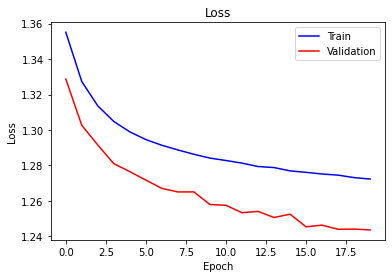

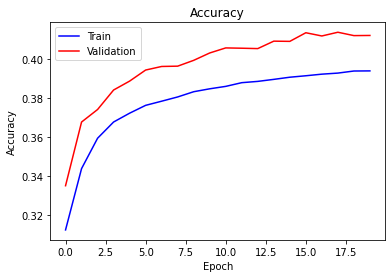

In [ ]:
plot_history(model_history)

In [ ]:
from sklearn.metrics import classification_report
y_pred = new_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

AxisError: ignored

In [34]:
!mkdir -p saved_model
model_CNN.save('saved_model/CNN_model') 


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/CNN_model/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 64)             18176     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 128)            66048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 133,892
Trainable params: 133,892
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = (y_pred > 0.5) 

In [ ]:
y_pred[1]

array([False, False, False, False])